In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from segnet import *
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\Admin\anaconda3\envs\dfine\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
image_path = ["C:/Users/Admin/Desktop/car/"+"data"+i+"/"+"data"+i+"/CameraRGB/" for i in ['A', 'B']]
mask_path = ["C:/Users/Admin/Desktop/car/"+"data"+i+"/"+"data"+i+"/CameraSeg/" for i in ['A', 'B']]

In [51]:
input = torch.rand(4,4,256,256)
mask = torch.rand(4,256,256).long()

In [52]:
loss = DiceCrossEntropyLoss()

In [53]:
loss(input, mask)

tensor(1.1582)

In [48]:
import torch

def dice_loss(pred, target, smooth=1e-6):
    # Dự đoán (sau softmax) và nhãn one-hot
    pred = torch.softmax(pred, dim=1)  # [batch_size, num_classes, H, W]
    target = torch.nn.functional.one_hot(target, num_classes=pred.shape[1])  # [batch_size, H, W, num_classes]
    target = target.permute(0, 3, 1, 2)  # [batch_size, num_classes, H, W]

    # Tính Dice Loss
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
    dice = 2.0 * intersection / (union + smooth)
    return 1 - dice.mean()  # Dice Loss = 1 - Dice Score

class DiceCrossEntropyLoss(nn.Module):
    def __init__(self, weight_dice=0.5):
        super(DiceCrossEntropyLoss, self).__init__()
        self.weight_dice = weight_dice
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, logits, target):
        # Tính CrossEntropyLoss
        ce = self.ce_loss(logits, target)

        # Tính Dice Loss
        dice = dice_loss(logits, target)

        # Kết hợp hai hàm loss
        return (1 - self.weight_dice) * ce + self.weight_dice * dice


In [4]:
class DiceCrossEntropyLoss(nn.Module):
    def __init__(self, weight_dice=0.5):
        super(DiceCrossEntropyLoss, self).__init__()
        self.weight_dice = weight_dice
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, logits, target):
        # Tính CrossEntropyLoss
        ce = self.ce_loss(logits, target)

        # Tính Dice Loss
        dice = dice_loss(logits, target)

        # Kết hợp hai hàm loss
        return (1 - self.weight_dice) * ce + self.weight_dice * dice


In [3]:
model = Segnet(21, version="n", class_names = [])
model=model.to("cuda")

In [4]:
model(torch.rand(1,3,1024,1024).to("cuda")).shape

c:\Users\Admin\anaconda3\envs\dfine\Lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
c:\Users\Admin\anaconda3\envs\dfine\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


torch.Size([1, 21, 1024, 1024])

In [6]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [7]:
count_parameters(model)

5164903

In [31]:
imgsz = 256

In [40]:
class CustomDataset(Dataset):
  
    def __init__(self, root_dir, mode='train', transform=None):
        self.root_dir = root_dir
        self.mode = mode  # 'train' or 'valid'
        self.transform = transform
        
        # Set image and mask directories based on mode
        self.img_dir = os.path.join(root_dir, mode, 'images')
        self.mask_dir = os.path.join(root_dir, mode, 'masks')

        self.image_names = []
        self.mask_names = []

        # Collect image and mask filenames
        for n in os.listdir(self.img_dir):
            self.image_names.append(os.path.join(self.img_dir, n))
            self.mask_names.append(os.path.join(self.mask_dir, n.replace('.jpg', '.npy')))  

    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

        mask_name = self.mask_names[idx]
        mask = np.load(mask_name)
        mask = torch.from_numpy(mask).long()

        if self.transform:
            image = self.transform['Image'](image) 
            # mask = self.transform['Mask'](mask)
       
        sample = {'image': image, 'mask': mask}
        return sample


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
    

data_transforms = {
        'Image': transforms.Compose([
            transforms.ToPILImage(),                     
            transforms.Resize((imgsz, imgsz)),           
            transforms.ToTensor(),           
            transforms.Normalize(mean, std)          
        ]),
        'Mask': transforms.Compose([
            transforms.ToPILImage(),                   
            transforms.Resize((imgsz, imgsz)),          
            transforms.ToTensor()
        ])
    }

    # Dataset cho Train và Test
root_dir = r"C:\Users\Admin\Desktop\Egg_Monitoring.v1i.coco-segmentation"
train_dataset = CustomDataset(root_dir, mode = "train", transform=data_transforms)
val_dataset = CustomDataset(root_dir, mode = "valid", transform=data_transforms)


train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=3, shuffle=False)

In [44]:
train_dataset[0]['mask'].shape

torch.Size([640, 640])

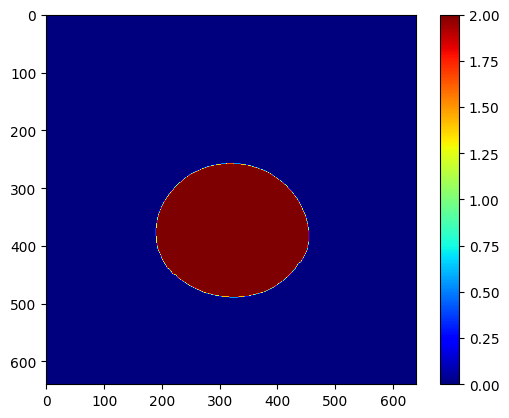

In [43]:
mask = train_dataset[0]['mask'].numpy()  # Chuyển tensor thành NumPy array nếu cần

# Nếu mask có nhiều lớp, bạn có thể chọn lớp hoặc vẽ một cách khác.
plt.imshow(mask, cmap='jet')  # Chọn cmap phù hợp (ví dụ: 'jet', 'gray', 'viridis', ...)
plt.colorbar()  # Thêm thanh màu nếu cần
plt.show()

In [10]:
dataloaders, image_datasets = dataload(image_path, mask_path)

In [ ]:
import csv
import copy
import time
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score, roc_auc_score

def train_model(model, criterion, dataloaders, optimizer, metrics, bpath, num_epochs=3):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    # Use gpu if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #xm.xla_device() 
    model.to(device)
    # Initialize the log file for training and testing loss and metrics
    fieldnames = ['epoch', 'Train_loss', 'Test_loss'] + \
        [f'Train_{m}' for m in metrics.keys()] + \
        [f'Test_{m}' for m in metrics.keys()]
    with open(os.path.join(bpath, 'log.csv'), 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)
        # Each epoch has a training and validation phase
        # Initialize batch summary
        batchsummary = {a: [0] for a in fieldnames}

        for phase in ['Train', 'Test']:
            if phase == 'Train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            # Iterate over data.
            for sample in iter(dataloaders[phase]):
                inputs = sample['image'].to(device)
                # inputs.requires_grad = True 
                masks = sample['mask'].to(device)
                masks = masks.squeeze(1)
                # masks.requires_grad = True 
                # zero the parameter gradients
                optimizer.zero_grad()

                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, masks)
                    y_pred = torch.argmax(outputs, dim=1).data.cpu().numpy().ravel()
                    y_true = masks.data.cpu().numpy().ravel()
#                     print(y_pred, y_true)
                    for name, metric in metrics.items():
                        if name == 'f1_score':
                            # Use a classification threshold of 0.1
                            batchsummary[f'{phase}_{name}'].append(
                                metric(y_true > 0, y_pred > 0.1))
                        else:
                            batchsummary[f'{phase}_{name}'].append(
                                metric(y_true.astype('uint8'), y_pred))

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()
            batchsummary['epoch'] = epoch
            epoch_loss = loss
            batchsummary[f'{phase}_loss'] = epoch_loss.item()
            print('{} Loss: {:.4f}'.format(
                phase, loss))
        for field in fieldnames[3:]:
            batchsummary[field] = np.mean(batchsummary[field])
        print(batchsummary)
        with open(os.path.join(bpath, 'log.csv'), 'a', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writerow(batchsummary)
            # deep copy the model
            if phase == 'Test' and loss < best_loss:
                best_loss = loss
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Lowest Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
#     torch.save(model, os.path.join(bpath, '50epochs_weights.pt'))
    return model

epochs = 20
bpath = "C:/Users/Admin/Desktop/"

# Specify the loss function
criterion = DiceCrossEntropyLoss(weight_dice=0.5)
# Specify the optimizer with a lower learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Specify the evalutation metrics
metrics = {'f1_score': f1_score} #, 'auroc': roc_auc_score}

trained_model=train_model(model, criterion, dataloaders,optimizer, bpath=bpath, metrics=metrics, num_epochs=epochs)
# xmp.spawn(train_model, args=(model, criterion, dataloaders, optimizer, bpath=bpath, metrics=metrics, num_epochs=num_epochs))

torch.save(trained_model, os.path.join(bpath, f'{epochs}epochs_weights.pt'))

Epoch 1/1
----------


ValueError: dict contains fields not in fieldnames: 'Train_recall_class_1', 'Train_recall_class_3', 'Train_recall_class_0', 'Train_accuracy', 'Train_precision_class_0', 'Train_iou_class_0', 'Train_recall_class_4', 'Train_mean_iou', 'Train_precision_class_2', 'Train_iou_class_2', 'Train_precision_class_4', 'Train_iou_class_1', 'Train_iou_class_3', 'Train_precision_class_3', 'Train_precision_class_1', 'Train_recall_class_2', 'Train_iou_class_4'

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score, jaccard_score

def validate_model(model, dataloader, criterion, device, num_classes):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    y_true_all = []
    y_pred_all = []

    with torch.no_grad():
        for sample in iter(dataloader):
            inputs = sample['image'].to(device)
            masks = sample['mask'].to(device)
            masks = masks.squeeze(1)

            outputs = model(inputs)
            loss = criterion(outputs, masks)
            total_loss += loss.item()

            y_pred = torch.argmax(outputs, dim=1).data.cpu().numpy().ravel()
            y_true = masks.data.cpu().numpy().ravel()

            y_true_all.extend(y_true)
            y_pred_all.extend(y_pred)

    # Calculate metrics
    precision = precision_score(y_true_all, y_pred_all, average=None, labels=range(num_classes), zero_division=0)
    recall = recall_score(y_true_all, y_pred_all, average=None, labels=range(num_classes), zero_division=0)
    accuracy = accuracy_score(y_true_all, y_pred_all)
    iou = jaccard_score(y_true_all, y_pred_all, average=None, labels=range(num_classes), zero_division=0)

    # Calculate class-wise accuracy
    class_accuracy = []
    for i in range(num_classes):
        class_mask = (np.array(y_true_all) == i)
        if np.sum(class_mask) > 0:
            class_accuracy.append(np.mean(np.array(y_pred_all)[class_mask] == np.array(y_true_all)[class_mask]))
        else:
            class_accuracy.append(0.0)  # If no samples for this class, set accuracy to 0

    # Calculate mean metrics for 'all'
    mean_precision = np.mean(precision)
    mean_recall = np.mean(recall)
    mean_iou = np.mean(iou)

    return {
        'loss': total_loss / len(dataloader),
        'precision': precision,
        'recall': recall,
        'accuracy': accuracy,
        'iou': iou,
        'class_accuracy': class_accuracy,
        'mean_precision': mean_precision,
        'mean_recall': mean_recall,
        'mean_iou': mean_iou
    }

def print_validation_results(metrics, num_classes):
    print("Class\t\tP\t\tR\t\tAcc\t\tmIOU")
    print("-------------------------------------------------------------")
    
    # Print results for 'all'
    print(f"all\t\t{metrics['mean_precision']:.4f}\t\t{metrics['mean_recall']:.4f}\t\t{metrics['accuracy']:.4f}\t\t{metrics['mean_iou']:.4f}")
    
    # Print results for each class
    for i in range(num_classes):
        print(f"class{i+1}\t\t{metrics['precision'][i]:.4f}\t\t{metrics['recall'][i]:.4f}\t\t{metrics['class_accuracy'][i]:.4f}\t\t{metrics['iou'][i]:.4f}")
# Example usage in the training loop
num_classes = 10  # Replace with the actual number of classes in your dataset
for epoch in range(1, num_epochs + 1):
    print(f'Epoch {epoch}/{num_epochs}')
    print('-' * 10)
    
    # Training phase (omitted for brevity)
    
    # Validation phase
    val_metrics = validate_model(model, dataloaders['Test'], criterion, device, num_classes)
    print_validation_results(val_metrics, num_classes)

In [26]:
# val_metrics = validate_model(model, dataloaders['Test'], criterion, device, num_classes=21)
print_validation_results(val_metrics, num_classes = 21)

Class		P		R		Acc		mIOU
-------------------------------------------------------------
all		0.1503		0.1705		0.7040		0.1317
class1		0.9770		0.8375		0.8375		0.8214
class2		0.0228		0.0000		0.0000		0.0000
class3		0.0000		0.0000		0.0000		0.0000
class4		0.0545		0.0000		0.0000		0.0000
class5		0.0000		0.0000		0.0000		0.0000
class6		0.0056		0.0001		0.0001		0.0001
class7		0.0002		0.0000		0.0000		0.0000
class8		0.7936		0.9453		0.9453		0.7587
class9		0.0023		0.0000		0.0000		0.0000
class10		0.4293		0.9275		0.9275		0.4154
class11		0.8710		0.8680		0.8680		0.7691
class12		0.0000		0.0000		0.0000		0.0000
class13		0.0002		0.0027		0.0027		0.0002
class14		0.0000		0.0000		0.0000		0.0000
class15		0.0000		0.0000		0.0000		0.0000
class16		0.0000		0.0000		0.0000		0.0000
class17		0.0000		0.0000		0.0000		0.0000
class18		0.0000		0.0000		0.0000		0.0000
class19		0.0000		0.0000		0.0000		0.0000
class20		0.0000		0.0000		0.0000		0.0000
class21		0.0000		0.0000		0.0000		0.0000


In [12]:
import torch

def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"Total parameters: {total_params}")
    print(f"Trainable parameters: {trainable_params}")
    
    return total_params, trainable_params


In [9]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
    

data_transform = {
        'Train': transforms.Compose([
            transforms.ToPILImage(),                     
            transforms.Resize((imgsz, imgsz)),           
            transforms.ToTensor(),           
            transforms.Normalize(mean, std)          
        ]),
        'Test': transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((imgsz, imgsz)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ]),

        'Mask': transforms.Compose([
            transforms.ToPILImage(),                   
            transforms.Resize((imgsz, imgsz)),          
            transforms.ToTensor()
        ])
    }

In [41]:
model_path = "C:/Users/Admin/Documents/GitHub/Eggnet/best_model.pth"
img_path = r"C:\Users\Admin\Desktop\car\dataA\dataA\CameraRGB\02_01_171.png"
seg_path = r"C:\Users\Admin\Desktop\car\dataA\dataA\CameraSeg\02_01_171.png"
# Chọn thiết bị (CPU hoặc GPU nếu có)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Tải trọng số mô hình lên device
state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict)
model.to(device)  # Đưa model về GPU hoặc CPU
model.eval()  # Chuyển sang chế độ đánh giá

# Load và xử lý ảnh đầu vào
originalImage = cv2.imread(img_path)
temp_img = originalImage
originalImage = cv2.cvtColor(originalImage, cv2.COLOR_BGR2RGB)

originalImage = data_transform['Train'](originalImage).to(device)  # Chuyển ảnh lên device

# Dự đoán
with torch.no_grad():
    a = model(originalImage.unsqueeze(0))  # Thêm batch dimension
    y_pred = torch.argmax(a, dim=1).squeeze(0).cpu().numpy()  # Chuyển kết quả về CPU nếu cần

(-0.5, 255.5, 255.5, -0.5)

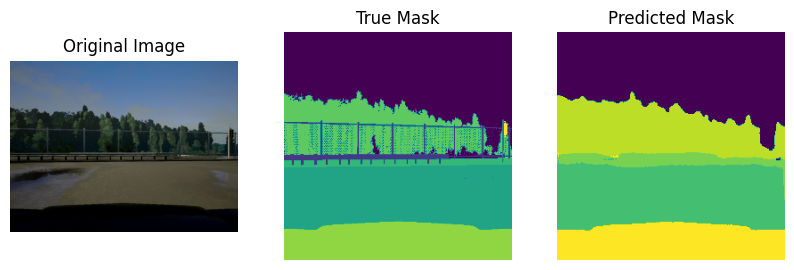

In [42]:
fig, arr=plt.subplots(1,3, figsize=(10,10))

arr[0].imshow(cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB))
arr[0].set_title('Original Image')
arr[0].axis('off')
arr[1].imshow(cv2.resize(cv2.imread(seg_path)[:,:,2], (imgsz, imgsz)))
arr[1].set_title('True Mask')
arr[1].axis('off')
arr[2].imshow(y_pred)
arr[2].set_title('Predicted Mask')
arr[2].axis('off')

In [7]:
import json

# Đường dẫn đến file annotation của COCO
coco_json_path = r"C:\Users\Admin\Desktop\Egg_Monitoring.v1i.coco-segmentation\test\_annotations.coco.json"

# Đọc file JSON
with open(coco_json_path, "r") as f:
    coco_data = json.load(f)

# Lấy danh sách category
class_names = {cat["id"]: cat["name"] for cat in coco_data["categories"]}

print(class_names)


{0: 'Labeling-eggshells', 1: '15days', 2: '5days', 3: 'break', 4: 'crack'}


In [12]:
for x in range(1, len(class_names)):
    print(x)

1
2
3
4


In [24]:
import numpy as np

def acc_per_class(y_true, y_pred):
    """
    Tính độ chính xác cho từng lớp.
    
    Parameters:
        y_true (np.array): Nhãn thực tế.
        y_pred (np.array): Nhãn dự đoán.
    
    Returns:
        dict: Độ chính xác cho từng lớp.
    """
    # Số lớp
    num_classes = len(np.unique(y_true))
    
    accuracies = {}
    for class_id in range(num_classes):
        class_mask = (y_true == class_id)
        correct = (y_true[class_mask] == y_pred[class_mask]).sum()
        total = class_mask.sum()
        accuracy = correct / total if total > 0 else 0
        accuracies[class_id] = accuracy
    
    return accuracies


# Ví dụ sử dụng
y_true = np.array([0, 1, 2, 2, 1, 0, 0, 1])
y_pred = np.array([0, 1, 1, 2, 1, 0, 2, 1])

accuracies = acc_per_class(y_true, y_pred)



In [25]:
accuracies

{0: 0.6666666666666666, 1: 1.0, 2: 0.5}

In [21]:
class_names[0]

'Labeling-eggshells'

In [19]:
accuracies[0]

0.6666666666666666

In [16]:
mean_accuracy_excluding_first = np.mean(list(accuracies.values())[1:])

In [17]:
mean_accuracy_excluding_first

0.75